<a href="https://colab.research.google.com/github/megsum/Voxelmorph-on-Retina-Data/blob/main/VoxelMorph_on_Retina_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The VoxelMorph tutorial provided here: https://github.com/voxelmorph/voxelmorph is heavily used for this project. It was duplicated and then modified for our dataset. We took the tutorial and applied it to a new dataset focused on Retina information. 

In [ ]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# imports
import os, sys
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import voxelmorph as vxm
import neurite as ne
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import io
from skimage.filters import gaussian
from skimage.transform import pyramid_gaussian
from skimage.transform import resize
from skimage.color import rgb2gray


# Dataset Preprocessing

Dataset from: https://www.kaggle.com/code/scratchpad/notebookdebdf925c3/edit

In [ ]:
# Import Dataset
validation_images = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/School/Cmput 617/Final Project/FIRE/Images/Validation'):
    for filename in filenames:
        J = rgb2gray(io.imread(os.path.join(dirname, filename))).astype(np.float32)/255.0
        validation_images.append(J)

fixed_images = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/School/Cmput 617/Final Project/FIRE/Images/Fixed'):
    for filename in filenames:
        I = rgb2gray(io.imread(os.path.join(dirname, filename))).astype(np.float32)/255.0
        fixed_images.append(I)


Text(0.5, 1.0, 'Moving Image')

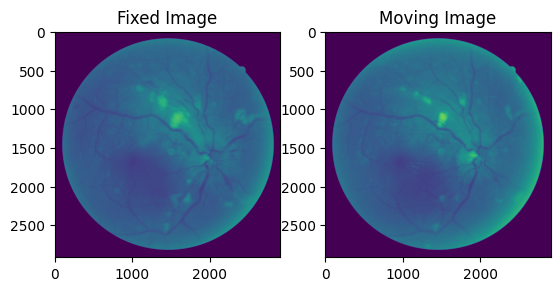

In [ ]:
fixed_images = tf.constant(fixed_images)
validation_images = tf.constant(validation_images)

# plot
%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(fixed_images[0])
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(fixed_images[1])
plt.title("Moving Image")


Text(0.5, 1.0, 'Moving Image')

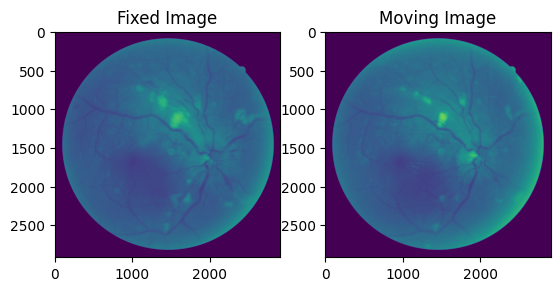

In [ ]:
# Plot
%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(fixed_images[0])
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(fixed_images[1])
plt.title("Moving Image")


# CNN Model

In [ ]:
# Using gray images as the rgb images have too many dimensions.
fixed_images_tensor = tf.convert_to_tensor(fixed_images)
validation_images_tensor = tf.convert_to_tensor(validation_images)

# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*fixed_images_tensor.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

print (fixed_images_tensor.shape)

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

(26, 2912, 2912)


In [ ]:
print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

input shape:  (None, 2912, 2912, 2)
output shape: (None, 2912, 2912, 16)


In [ ]:
# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 2912, 2912, 2)


# Loss Function

In [ ]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])
print (moved_image_tensor.shape)

(None, 2912, 2912, 1)


In [ ]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

In [ ]:
# build model using VxmDense
inshape = fixed_images_tensor.shape[1:]
print(inshape)
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

(2912, 2912)


In [ ]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 2912, 2912, 1), (None, 2912, 2912, 1)
output shape: (None, 2912, 2912, 1), (None, 2912, 2912, 2)


In [ ]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [ ]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train Model

In [ ]:
def vxm_data_generator(x_data, batch_size=2):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=1)
        moving_images = x_data[np.newaxis, idx1[0], ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=1)
        fixed_images = x_data[np.newaxis, idx2[0], ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield inputs, outputs

2


Text(0.5, 1.0, 'Moving Image')

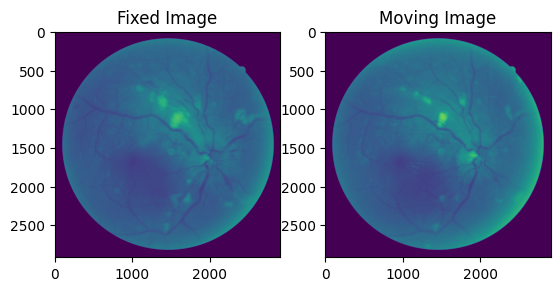

In [ ]:
# let's test it
train_generator = vxm_data_generator(fixed_images_tensor)
in_sample, out_sample = next(train_generator)
print (len(out_sample[1]))

# visualize
images = [img[0, :, :] for img in in_sample + out_sample] 

# Plot the grayscale images again
%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(fixed_images[0])
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(fixed_images[1])
plt.title("Moving Image")

I appear to be running out of compute and haven't been able to get a full run of this code. :'(. I'm running out of time, but will try to investigate on Tuesday.

In [ ]:
nb_epochs = 1
steps_per_epoch = 1
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

<ipython-input-54-57815c9aca84>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);


1/1 - 11s - loss: 1.0569e-07 - vxm_dense_transformer_loss: 1.0569e-07 - vxm_dense_flow_loss: 1.3070e-17 - 11s/epoch - 11s/step


In [ ]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

# Registration

In [ ]:
# let's get some data
val_generator = vxm_data_generator(validation_images_tensor, batch_size = 1)
val_input, _ = next(val_generator)

In [ ]:
val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 13s 13s/step


In [ ]:
# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

1/1 [==============================] - 0s 408ms/step
663 ms ± 42.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


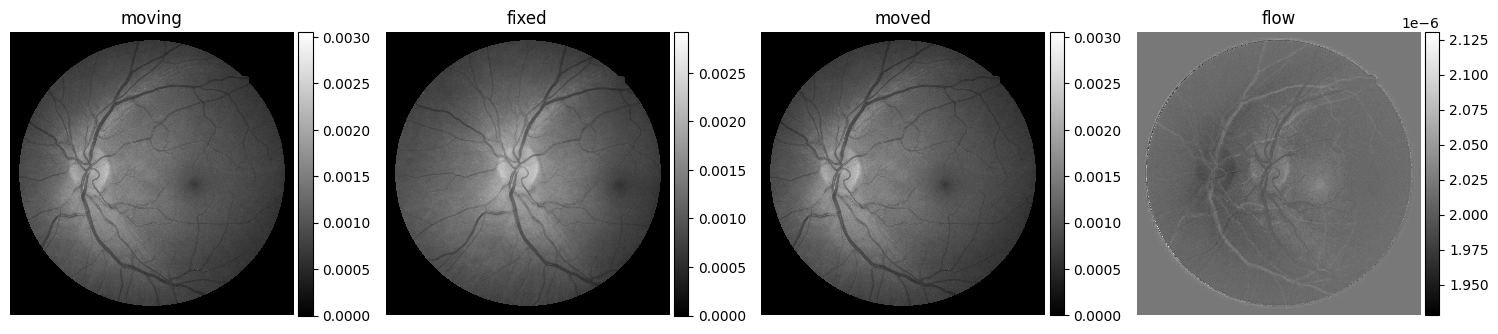

In [ ]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);